In [1]:
#Author Kosmas Apostolidis 
#AM:4259
from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd
from random import randrange
from random import choice
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input , Dense
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cdist

In [2]:
dir_train_data = r'C:\Users\cosma\Desktop\EVERYTHING\MachineLearning\ML2022 Homework2   4259\all_faces\train_data' #Local directory with the faces dataset
faces_from_train_dataset = [] #A list with faces
y_true = [] #True labels                
label = 0   #0...49

agglo_clust_accuracy_scores = []
agglo_clust_precision   = []
agglo_clust_recall      = []
agglo_clust_F_measures  = []
agglo_clust_purity_scores = []

#Distance metrics used to K-Means algorithm
distance_metrics = ['euclidean' , 'cosine'] 

list_accuracy_scores  = []
list_F_measures       = []
list_purity_scores    = []
list_precision_scores = []
list_recall_scores    = []

In [3]:
def get_face_from_train_dataset(list_faces,rnd_person):
    rnd_face   = randrange(50)   #Generate random integer between 0 and 49
    if rnd_face > len(list_faces) - 1:
        rnd_face           = randrange(len(list_faces) - 1)   #Generate random integer between 0 and len(person_imgs) - 1
        face               = list_faces[rnd_face] #Get the last image of tthe rnd person
        train_colored_face = np.asarray(Image.open(dir_train_data+"\\"+str(rnd_person)+"\\"+str(face)))
        rbg_to_grayscale   = np.mean(train_colored_face , axis = 2) #convert a color image 3D array to a grayscale 2D
        faces_from_train_dataset.append(rbg_to_grayscale) #Append the train_img to the list
        y_true.append(label)
    else:
        face                = list_faces[rnd_face] #Get the random image of the train dataset
        train_colored_face  = np.asarray(Image.open(dir_train_data+"\\"+str(rnd_person)+"\\"+str(face)))
        rbg_to_grayscale    = np.mean(train_colored_face , axis = 2) #convert a color image 3D array to a grayscale 2D
        faces_from_train_dataset.append(rbg_to_grayscale) #Append the img to the list
        y_true.append(label)

In [4]:
#Here i choose 10 random people from the dataset and for each one of them i choose 50 random pictures
#Get 50 random images of 10 random people
for i in range(10):
    counter     = 0 
    person      = randrange(4000)     #Generate random integer between 0 and 3999
    list_faces_from_train_dataset = os.listdir(dir_train_data+"\\"+str(person)) 
    while counter < 50:
        get_face_from_train_dataset(list_faces_from_train_dataset,person)
        counter += 1
    label += 1

In [5]:
faces_from_train_dataset          = np.array(faces_from_train_dataset)  
# Global centering (focus on one feature, centering all samples)
faces_centered_from_train_dataset = faces_from_train_dataset - faces_from_train_dataset.mean(axis = 0)
#Reshape
faces_centered_from_train_dataset = faces_centered_from_train_dataset.reshape(500 , -1)
print("dataset shape:"+str(faces_centered_from_train_dataset.shape)+". It has N = 500 samples and dimension d = 4096")

dataset shape:(500, 4096). It has N = 500 samples and dimension d = 4096


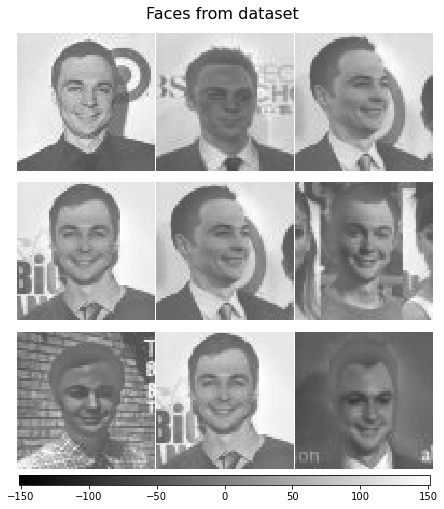

In [6]:
n_row, n_col = 3,3
n_components = n_row * n_col
image_shape = (64,64)


def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()
    
plot_gallery("Faces from dataset", faces_centered_from_train_dataset[:n_components])

In [7]:
# Principal Component Analysis(PCA) finds the directions of maximum variance in high-dimensional data 
# and projects it onto a new subspace with equal or fewer dimensions than the original one

train_pca_100 = PCA(n_components = 100) #Keep the first 100
pca_100_converted_training_data = train_pca_100.fit_transform(faces_centered_from_train_dataset)
print("The data reduced from "+str(faces_centered_from_train_dataset.shape)+" to "+str(pca_100_converted_training_data.shape))

The data reduced from (500, 4096) to (500, 100)


In [8]:
train_pca_50 = PCA(n_components = 50)
pca_50_converted_training_data = train_pca_50.fit_transform(faces_centered_from_train_dataset)
print("The data reduced from "+str(faces_centered_from_train_dataset.shape)+" to "+str(pca_50_converted_training_data.shape))

The data reduced from (500, 4096) to (500, 50)


In [9]:
train_pca_25 = PCA(n_components = 25)
pca_25_converted_training_data = train_pca_25.fit_transform(faces_centered_from_train_dataset)
print("The data reduced from "+str(faces_centered_from_train_dataset.shape)+" to "+str(pca_25_converted_training_data.shape))

The data reduced from (500, 4096) to (500, 25)


In [10]:
#Inputs to Agglomerative Clustering and K-Means algorithm
inputs = [pca_100_converted_training_data,pca_50_converted_training_data,pca_25_converted_training_data]

In [11]:
#Defining kmeans function
def kmeans(x,k,distance_metric,no_of_iterations):
    idx = np.random.choice(len(x), k, replace=False)
    #Randomly choosing Centroids 
    centroids = x[idx, :] #Step 1
     
    #finding the distance between centroids and all the data points
    distances = cdist(x, centroids ,distance_metric) #Step 2
     
    #Centroid with the minimum Distance
    points = np.array([np.argmin(i) for i in distances]) #Step 3
     
    #Repeating the above steps for a defined number of iterations
    #Step 4
    for _ in range(no_of_iterations): 
        centroids = []
        for idx in range(k):
            #Updating Centroids by taking mean of Cluster it belongs to
            if np.all(x[points == idx]) == 0:
                temp_cent = 0
                centroids.append(temp_cent)
            else:
                temp_cent = x[points==idx].mean(axis=0) 
                centroids.append(temp_cent)
 
        centroids = np.vstack(centroids) #Updated Centroids 
         
        distances = cdist(x, centroids , distance_metric)
        points = np.array([np.argmin(i) for i in distances])
         
    return points

In [12]:
#Implementation of purity_score function
def purity_score(cm , y_true, y_pred):
    # return purity score
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm) 

In [13]:
#A function that calculates the true positives , false positives , true negatives and false negatives
def calculate_TP_FP_TN_FN(cm):
    FP = cm.sum(axis = 0) - np.diag(cm) #False Positives
    FN = cm.sum(axis = 1) - np.diag(cm) #False Negatives
    TP = np.diag(cm) #True Positives
    TN = cm.sum() - (FP + FN + TP) #True Negatives
    
    total_TP = sum(TP) #Total True Positives
    total_TN = sum(TN) #Total True Negatives
    total_FP = sum(FP) #Total False Positives
    total_FN = sum(FN) #Total False Negatives
    
    return total_TP , total_FP , total_TN , total_FN

In [14]:
def calculate_accuracy_precision_recall_F_measure(TP,FP,TN,FN):
    F_measure , precision , recall , accuracy = 0 , 0 , 0 , 0 
    a = 1
    precision  = TP / (TP + FP) #Calculation of precision score
    recall     = TP / (TP + FN) #Calculation of recall score
    F_measure  = (1 + a) / ( (1 / precision) + (a / recall) ) #Caclculation of F_measure score
    accuracy   = (TP + TN) / (TP + TN + FP + FN) #Calculation of accuracy
    return accuracy , precision , recall , F_measure

In [15]:
#Calculation of K-Means with Euclidean/Cosine purity_scores and F_measures

for dm in distance_metrics:
    for inp in inputs:
        y_pred            = kmeans(inp , 10 , dm , 1000)           #The predictions of K-Means Algorithm
        cm                = confusion_matrix(y_true , y_pred)      #Calculate the confusion matrix
        TP , FP , TN , FN = calculate_TP_FP_TN_FN(cm)              #Calculate TP , FP , TN , FN
        accuracy , precision , recall  , F_measure = calculate_accuracy_precision_recall_F_measure(TP , FP , TN , FN) #Calculation of total F measure
        purity            = purity_score(cm , y_true , y_pred)     #Calculate purity score
        list_F_measures.append(F_measure)
        list_purity_scores.append(purity)
        list_precision_scores.append(precision)
        list_recall_scores.append(recall)
        list_accuracy_scores.append(accuracy)

In [16]:
euclidean_precision_scores= [list_precision_scores[0], list_precision_scores[1]  , list_precision_scores[2]]
euclidean_recall_scores   = [list_recall_scores[0]   , list_recall_scores[1]     , list_recall_scores[2]]
euclidean_F_measures      = [list_F_measures[0]      , list_F_measures[1]        , list_F_measures[2]]
euclidean_purity_scores   = [list_purity_scores[0]   , list_purity_scores[1]     , list_purity_scores[2]]
euclidean_accuracy_scores = [list_accuracy_scores[0] , list_accuracy_scores[1]   , list_accuracy_scores[2]]

cosine_precision_scores   = [list_precision_scores[3] , list_precision_scores[4] , list_precision_scores[5]] 
cosine_recall_scores      = [list_recall_scores[3]    , list_recall_scores[4]    , list_recall_scores[5]]
cosine_F_measures         = [list_F_measures[3]       , list_F_measures[4]       , list_F_measures[5]]
cosine_purity_scores      = [list_purity_scores[3]    , list_purity_scores[4]    , list_purity_scores[5]]
cosine_accuracy_scores    = [list_accuracy_scores[3]  , list_accuracy_scores[4]  , list_accuracy_scores[5]]

In [17]:
print("K-means with Euclidean distance metric")
print("dimension of data:"+str(inputs[0].shape)+"\naccuracy:"+str(euclidean_accuracy_scores[0])+"\nprecision:"+str(euclidean_precision_scores[0])+"\nrecall:"+str(euclidean_recall_scores[0])+"\nF-measure:"+str(euclidean_F_measures[0])+"\npurity:"+str(euclidean_purity_scores[0]))
print("\ndimension of data:"+str(inputs[1].shape)+"\naccuracy:"+str(euclidean_accuracy_scores[1])+"\nprecision:"+str(euclidean_precision_scores[1])+"\nrecall:"+str(euclidean_recall_scores[1])+"\nF-measure:"+str(euclidean_F_measures[1])+"\npurity:"+str(euclidean_purity_scores[1]))
print("\ndimension of data:"+str(inputs[2].shape)+"\naccuracy:"+str(euclidean_accuracy_scores[2])+"\nprecision:"+str(euclidean_precision_scores[2])+"\nrecall:"+str(euclidean_recall_scores[2])+"\nF-measure:"+str(euclidean_F_measures[2])+"\npurity:"+str(euclidean_purity_scores[2]))
print("\n\nK-means with Cosine distance metric")
print("dimension of data:"+str(inputs[0].shape)+"\naccuracy:"+str(cosine_accuracy_scores[0])+"\nprecision:"+str(cosine_precision_scores[0])+"\nrecall:"+str(cosine_recall_scores[0])+"\nF-measure:"+str(cosine_F_measures[0])+"\npurity:"+str(cosine_purity_scores[0]))
print("\ndimension of data:"+str(inputs[1].shape)+"\naccuracy:"+str(cosine_accuracy_scores[1])+"\nprecision:"+str(cosine_precision_scores[1])+"\nrecall:"+str(cosine_recall_scores[1])+"\nF-measure:"+str(cosine_F_measures[1])+"\npurity:"+str(cosine_purity_scores[1]))
print("\ndimension of data:"+str(inputs[2].shape)+"\naccuracy:"+str(cosine_accuracy_scores[2])+"\nprecision:"+str(cosine_precision_scores[2])+"\nrecall:"+str(cosine_recall_scores[2])+"\nF-measure:"+str(cosine_F_measures[2])+"\npurity:"+str(cosine_purity_scores[2]))

K-means with Euclidean distance metric
dimension of data:(500, 100)
accuracy:0.8216
precision:0.108
recall:0.108
F-measure:0.108
purity:0.244

dimension of data:(500, 50)
accuracy:0.8084
precision:0.042
recall:0.042
F-measure:0.042
purity:0.286

dimension of data:(500, 25)
accuracy:0.8364
precision:0.182
recall:0.182
F-measure:0.182
purity:0.28


K-means with Cosine distance metric
dimension of data:(500, 100)
accuracy:0.826
precision:0.13
recall:0.13
F-measure:0.13
purity:0.292

dimension of data:(500, 50)
accuracy:0.8192
precision:0.096
recall:0.096
F-measure:0.096
purity:0.274

dimension of data:(500, 25)
accuracy:0.8276
precision:0.138
recall:0.138
F-measure:0.138
purity:0.232


In [18]:
agglo_clustering = AgglomerativeClustering(n_clusters = 10 , affinity = 'euclidean' , linkage = 'ward')

In [19]:
#Agglomerative Clustering
#Because linkage = 'ward' , only affinity = 'euclidean' is accepted.
#Affinity is the metric used to compute the linkage.

for inp in inputs:
    y_pred            = agglo_clustering.fit_predict(inp)
    cm                = confusion_matrix(y_true , y_pred)      #Calculate the confusion matrix
    TP , FP , TN , FN = calculate_TP_FP_TN_FN(cm)              #Calculate TP , FP , TN , FN
    accuracy , precision , recall  , F_measure = calculate_accuracy_precision_recall_F_measure(TP , FP , TN , FN) 
    purity            = purity_score(cm , y_true , y_pred)     #Calculate purity score
    agglo_clust_accuracy_scores.append(accuracy)
    agglo_clust_precision.append(precision)
    agglo_clust_recall.append(recall)
    agglo_clust_F_measures.append(F_measure)
    agglo_clust_purity_scores.append(purity)
    print("\n")
    print("dimension of data:"+str(inp.shape))
    print("The number of clusters found by the algorithm: "+str(agglo_clustering.n_clusters_))    
    print("Number of features seen during fit: "+str(agglo_clustering.n_features_in_)) 
    print("Number of leaves in the hierarchical tree: "+str(agglo_clustering.n_leaves_))      



dimension of data:(500, 100)
The number of clusters found by the algorithm: 10
Number of features seen during fit: 100
Number of leaves in the hierarchical tree: 500


dimension of data:(500, 50)
The number of clusters found by the algorithm: 10
Number of features seen during fit: 50
Number of leaves in the hierarchical tree: 500


dimension of data:(500, 25)
The number of clusters found by the algorithm: 10
Number of features seen during fit: 25
Number of leaves in the hierarchical tree: 500


In [20]:
print("Agglomerative Clustering")
print("\ndimension of data:"+str(inputs[0].shape)+"\naccuracy:"+str(agglo_clust_accuracy_scores[0])+"\nprecision:"+str(agglo_clust_precision[0])+"\nrecall:"+str(agglo_clust_recall[0])+"\nF-measure:"+str(agglo_clust_F_measures[0])+"\npurity:"+str(agglo_clust_purity_scores[0]))
print("\ndimension of data:"+str(inputs[1].shape)+"\naccuracy:"+str(agglo_clust_accuracy_scores[1])+"\nprecision:"+str(agglo_clust_precision[1])+"\nrecall:"+str(agglo_clust_recall[1])+"\nF-measure:"+str(agglo_clust_F_measures[1])+"\npurity:"+str(agglo_clust_purity_scores[1]))
print("\ndimension of data:"+str(inputs[2].shape)+"\naccuracy:"+str(agglo_clust_accuracy_scores[2])+"\nprecision:"+str(agglo_clust_precision[2])+"\nrecall:"+str(agglo_clust_recall[2])+"\nF-measure:"+str(agglo_clust_F_measures[2])+"\npurity:"+str(agglo_clust_purity_scores[2]))

Agglomerative Clustering

dimension of data:(500, 100)
accuracy:0.8292
precision:0.146
recall:0.146
F-measure:0.146
purity:0.288

dimension of data:(500, 50)
accuracy:0.8196
precision:0.098
recall:0.098
F-measure:0.098
purity:0.272

dimension of data:(500, 25)
accuracy:0.8248
precision:0.124
recall:0.124
F-measure:0.124
purity:0.298


In [21]:
x_train = faces_centered_from_train_dataset
print(x_train.shape)

(500, 4096)


In [22]:
#Implementation of AutoEncoder with architecture d - d/4 -M -d/4 -d, where d = 4096 and M = [100,50,25]

#Input to encoder
encoder_input  = Input(shape = (4096,))

#Encoder
encoder_output = Dense(1024 , activation= 'relu')(encoder_input)
latent_vector  = Dense(100 , activation = 'relu')(encoder_output)

#Decoder
decoder_input  = Dense(1024 , activation= 'relu')(latent_vector)
decoder_output = Dense(4096 , activation= 'relu')(decoder_input)

#Defining the model.Group layers into an object with training and inference features
autoencoder    = Model(inputs = encoder_input , outputs = decoder_output)

In [23]:
#Compile the AutoEncoder
autoencoder.compile(optimizer = 'adam' , loss = 'binary_crossentropy')

In [24]:
#Fit the train_data to the AutoEncoder
autoencoder.fit(
                x_train , x_train,
                epochs = 10,
                batch_size = 10,
                shuffle = True,
                )

Epoch 1/10
50/50 [==============================] - 2s 43ms/step - loss: -3.0610
Epoch 2/10
50/50 [==============================] - 2s 43ms/step - loss: 1.6210
Epoch 3/10
50/50 [==============================] - 2s 44ms/step - loss: 3.5171
Epoch 4/10
50/50 [==============================] - 2s 43ms/step - loss: 4.0232
Epoch 5/10
50/50 [==============================] - 2s 42ms/step - loss: 4.4199
Epoch 6/10
50/50 [==============================] - 2s 42ms/step - loss: 3.9754
Epoch 7/10
50/50 [==============================] - 2s 41ms/step - loss: 3.6716
Epoch 8/10
50/50 [==============================] - 2s 41ms/step - loss: 3.8426
Epoch 9/10
50/50 [==============================] - 2s 41ms/step - loss: 4.1905
Epoch 10/10
50/50 [==============================] - 2s 41ms/step - loss: 4.5538
